In [18]:
#| hide
%load_ext autoreload
%autoreload 2

# 評価

> Test

In [19]:
#|default_exp Comp

In [ ]:
#| hide
#| export
import jax.numpy as jnp
import jax.random as jrd
import jax
from jaxtyping import Float, Int, Array, PRNGKeyArray
from KalmanPaper import gen, EKF, VA, Exper, simple
from matplotlib import pyplot as plt
from typing import Tuple
from functools import partial

In [21]:
#| export
@partial(jax.jit, static_argnames=['N', 'T'])
def RMS(
    key: PRNGKeyArray,
    N: int,
    T: int,
    G: Float[Array, "{N} {N}"],
    w0: Float[Array, "{N}"],
    Sigma: Float[Array, "{N} {N}"],
    P0: Float[Array, "{N} {N}"], 
    propy1: Float
):
  X, Y, W, (Wtt_EKF, Ptt_EKF), (Wtt_VA, Ptt_VA, Xit_VA), \
    (Wtt_EM, Ptt_EM, Xit_EM) = Exper.exper(key, N, T, G, w0, Sigma, P0, propy1)
  W_norm = jnp.sqrt(jnp.sum(W**2, axis=1))
  RMS_Wtt_EKF = jnp.sqrt(jnp.sum((W - Wtt_EKF)**2, axis=1)) # shape: (T:)
  RMS_Wtt_VA = jnp.sqrt(jnp.sum((W - Wtt_VA)**2, axis=1))
  RMS_Wtt_EM = jnp.sqrt(jnp.sum((W - Wtt_EM)**2, axis=1))
  
  return W_norm, RMS_Wtt_EKF, RMS_Wtt_VA, RMS_Wtt_EM

In [22]:
N = 2
G = 1/2**8 * jnp.identity(N, dtype=jnp.float32)
Sigma = 5.0 * jnp.identity(N, dtype=jnp.float32)
w0 = jnp.ones((N,), dtype=jnp.float32)/jnp.sqrt(N)
propy1 = 0.5

W_norm, RMS_Wtt_EKF, RMS_Wtt_VA, RMS_Wtt_EM = RMS(
  key=jrd.PRNGKey(0), 
  N=2, 
  T=1000, 
  G=G,
  w0=w0,
  Sigma=Sigma,
  P0=G,
  propy1=propy1)

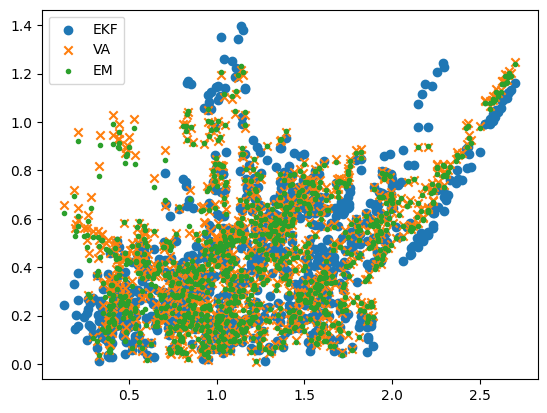

In [23]:
plt.scatter(W_norm, RMS_Wtt_EKF, label="EKF")
plt.scatter(W_norm, RMS_Wtt_VA, marker='x', label="VA")
plt.scatter(W_norm, RMS_Wtt_EM, marker='.', label="EM")
plt.legend()

In [24]:
#| export
@partial(jax.jit, static_argnames=['N', 'T'])
def losi_error(
    key: PRNGKeyArray,
    N: int,
    T: int,
    G: Float[Array, "{N} {N}"],
    w0: Float[Array, "{N}"],
    Sigma: Float[Array, "{N} {N}"],
    P0: Float[Array, "{N} {N}"], 
    propy1: Float
):
  X, Y, W, (Wtt_EKF, Ptt_EKF), (Wtt_VA, Ptt_VA, Xit_VA), \
    (Wtt_EM, Ptt_EM, Xit_EM) = Exper.exper(key, N, T, G, w0, Sigma, P0, propy1)
  true_line = simple.losi(jnp.sum(W[1:]*X[1:], axis=1))
  err_Wtt_EKF = (simple.losi(jnp.sum(Wtt_EKF[:-1]*X[1:], axis=1)) - true_line)**2
  err_Wtt_VA = (simple.losi(jnp.sum(Wtt_VA[:-1]*X[1:], axis=1)) - true_line)**2
  err_Wtt_EM = (simple.losi(jnp.sum(Wtt_EM[:-1]*X[1:], axis=1)) - true_line)**2
  
  return err_Wtt_EKF, err_Wtt_VA, err_Wtt_EM

In [25]:
N = 2
G = 1/2**8 * jnp.identity(N, dtype=jnp.float32)
Sigma = 5.0 * jnp.identity(N, dtype=jnp.float32)
w0 = jnp.ones((N,), dtype=jnp.float32)/jnp.sqrt(N)
propy1 = 0.5

RMS_Wtt_EKF, RMS_Wtt_VA, RMS_Wtt_EM = losi_error(
  key=jrd.PRNGKey(0), 
  N=2, 
  T=1000, 
  G=G,
  w0=w0,
  Sigma=Sigma,
  P0=G,
  propy1=propy1)

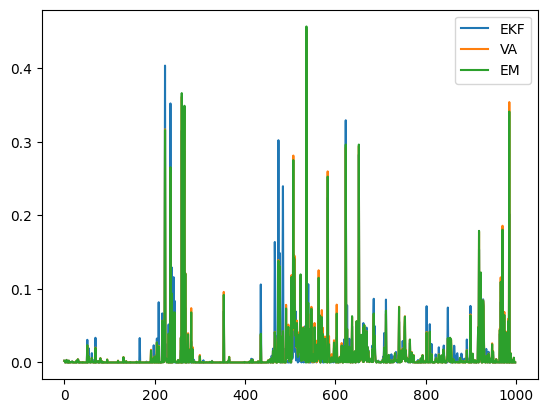

In [26]:
plt.plot(RMS_Wtt_EKF, label="EKF")
plt.plot(RMS_Wtt_VA, label="VA")
plt.plot(RMS_Wtt_EM, label="EM")
plt.legend()

In [27]:
sum(RMS_Wtt_EKF), sum(RMS_Wtt_VA), sum(RMS_Wtt_EM)

(Array(10.609799, dtype=float32),
 Array(11.298924, dtype=float32),
 Array(11.056256, dtype=float32))

In [28]:
jnp.array([1,2,3])[:-1]

Array([1, 2], dtype=int32)

In [29]:
#| hide
import nbdev; nbdev.nbdev_export()